This notebook illustrates the basic use of the Python look-up table readers and forward models.

First, how does pyORAC locate LUT files? (Some of these steps are introduced in the swath_examples notebook.) Obviously, if you know the path to the file you wish to open, you can just use that.

In [1]:
# Your local defaults provides a list of possible locations for LUTs as SAD_DIRS
from pyorac.local_defaults import SAD_DIRS, REGRESS_IN_DIR, REGRESS_OUT_DIR, GLOBAL_ATTRIBUTES
from pyorac.definitions import SETTINGS, FileName
from pyorac.regression_tests import REGRESSION_TESTS
import os.path

# We use a FileName instance to specify the instrument we're interested in
slstrb_l1_filename, _, _ = REGRESSION_TESTS["DAYSLSTRB"]
slstrb_file_obj = FileName(REGRESS_IN_DIR, slstrb_l1_filename)

# pyorac.definitions contains a dictionary with a ParticleType() for each LUT
text_ice_obj = SETTINGS["ICE"]

# This has methods to select the correct directory and generate LUT filenames
text_ice_dir = text_ice_obj.sad_dir(SAD_DIRS, slstrb_file_obj)
text_ice_name = text_ice_obj.sad_filename(slstrb_file_obj)
text_ice_path = os.path.join(text_ice_dir, text_ice_name)

For multilayer retrievals, you need tables that do not contain Rayleigh scattering. This is done using the keyword `sad_dir(rayleigh=False)`.

Next, we demonstrate the LUT readers. There are separate classes for the text and NCDF tables but they possess the same methods. (The differences are under-the-hood.)

The most basic interface is to call the table with the viewing conditions and it will return a dictionary of tables (that is available for all channels) interpolated to that point. Arguments can be scalars or arrays of the same length. The expectation is for arrays to iterate over channel.

In [2]:
from pyorac.lut import OracTextLut, OracNcdfLut

# Given the above, we can open the table using its path
text_ice = OracTextLut(text_ice_path)

# This isn't necessary but helps later code use the table
text_ice._particle = SETTINGS["ICE"]

# Then, we call the table for some random point
channels = (2, 8)
satzen, solzen, relazi = 30.0, 10.0, 15.0
optical_depth, effective_radius = 0.2, 10.0
text_ice(channels, satzen, solzen, relazi, optical_depth, effective_radius)

{'t_dv': array([0.20211921, 7.60781395]),
 't_dd': array([0.91913902, 0.84903219]),
 'r_dv': array([0.04686469, 0.00078207]),
 'r_dd': array([0.08090257, 0.00431037]),
 'ext': array([0.02087023, 0.01436373]),
 'ext_ratio': array([0.01007119, 0.00693126])}

This doesn't look like many tables, but that's because we asked for both solar and thermal channels.

There's also a class constructor that will do all of the work in the first cell for us! Let's demonstrate it by opening the NCDF version of the same table.

In [3]:
ncdf_ice_obj = SETTINGS["water-ice"]
ncdf_ice = OracNcdfLut.from_description(SAD_DIRS, ncdf_ice_obj, slstrb_file_obj)

ncdf_ice(channels, satzen, solzen, relazi, optical_depth, effective_radius)

{'t_dv': array([0.20220958, 0.9053748 ], dtype=float32),
 't_dd': array([0.91933656, 0.8498854 ], dtype=float32),
 'r_dv': array([0.0467236 , 0.00074845], dtype=float32),
 'r_dd': array([0.08065268, 0.00415955], dtype=float32),
 'ext': array([0., 0.], dtype=float32),
 'ext_ratio': array([0., 0.], dtype=float32)}

Most of those values are quite similar, except for $T_{dv}$ in channel 8. That's because there was a bug in that table for the text LUTs so it's actually using $T_{0d}$ for that calculation but that table wasn't needed for the thermal channels. We can get around that by turning off a flag. (This can also be done with a keyword when the instance is created.)

In [4]:
text_ice.t_dv_from_t_0d = False
tmp = text_ice(channels, satzen, solzen, relazi, optical_depth, effective_radius)
print(tmp["t_dv"])
text_ice.t_dv_from_t_0d = True

[0.20211921 7.60781395]


The second value is now quite similar to that from the NCDF table.

These interpolations are not exactly the same as those within the ORAC Fortran code as they use cubic spline interpolation along every axis (including channel). ORAC linearly interpolates over each angle before evaluating a pixel, then uses cubic splines within that plane. The pyORAC LUT interface includes the `state_space` method to produce such slices, which is useful for visualising the variation of the retrieval.

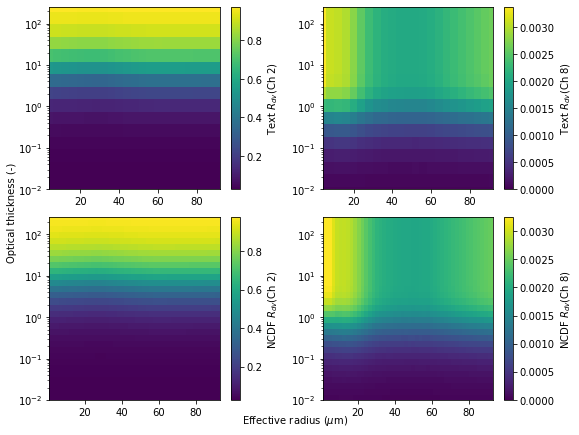

In [5]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(8, 6), subplot_kw=dict(yscale="log"))
for row, lut, label in zip(axes, (text_ice, ncdf_ice), ("Text", "NCDF")):
    # Calculate the interpolated slice of the LUT
    tables = lut.state_space(channels, satzen, solzen, relazi)
    
    # Generate the mesh of points that table is defined over
    xx, yy = lut.state_mesh()
    
    for i, ax in enumerate(row):
        # Channel is the last dimension to facilitate numpy broadcasting
        im = ax.pcolormesh(xx, yy, tables["r_dv"][...,i])
        fig.colorbar(im, ax=ax, label=label + r" $R_{dv}$" + "(Ch {})".format(channels[i]))
        
        ax.set_ylim((1e-2, None))
    
fig.text(0.5, 0.0, r"Effective radius ($\mu$m)", va="bottom", ha="center")
fig.text(0.0, 0.5, "Optical thickness (-)", va="center", ha="left", rotation=90.)

fig.tight_layout()

The LUT objects include three methods useful for calculations:

- `solar_constant` gives the solar radiance in each solar channel available, taking the day of the year as an argument;
- `rad2temp` converts radiances into brightness temperatures;
- `temp2rad` converts brightness temperatures into radiances.

In [6]:
# We can convert a single temperature into the radiance in each thermal channel
# easily. The function returns both the values and the gradients.
radiance, dr_dt = text_ice.temp2rad(280.0)
radiance

array([ 0.25506682, 82.41333701, 96.59836593,  0.25506682, 82.41333701,
       96.59836593])

In [7]:
# More typically, you will want to convert the brightness temperature in a
# particular channel. Use the sl argument to subscript the thermal channels
# of the table.
import numpy as np

# First, work out the index for channels 8 and 9. lut.thermal is a bool array
# specifying if each channel has a thermal component. lut.channels gives the number
# for each channel. lut.channels[lut.thermal] thus gives us the numbers of only
# the thermal channels. np.argmax then returns the index at which it first sees True.
ich8 = np.argmax(text_ice.channels[text_ice.thermal] == 8)
ich9 = np.argmax(text_ice.channels[text_ice.thermal] == 9)

radiance, dr_dt = text_ice.temp2rad([280.0, 285.0], sl=[ich8, ich9])
radiance

array([ 82.41333701, 104.23765062])

Next, we looked `pyorac.fm.PreprocessorFiles`, a simple wrapper for accessing data within the suite of ten files output by ORAC's preprocessor.

In [8]:
# Work out the name of the preprocessor files
slstrb_rootname = slstrb_file_obj.root_name(
    revision=2315,
    processor=GLOBAL_ATTRIBUTES["processor"],
    project=GLOBAL_ATTRIBUTES["project"],
    product_name=GLOBAL_ATTRIBUTES["product_name"]
)
# This could point at any of the files, but I tend to use the config file
slstrb_preprocpath = os.path.join(
    REGRESS_OUT_DIR, "conda_cld", "DAYSLSTRB", "pre", slstrb_rootname + ".config.nc"
)

import pyorac.fm as orac

preproc = orac.PreprocessorFiles(slstrb_preprocpath)

# Various useful dimensions are available
print(f"There are {preproc.nsolar} solar channels and {preproc.nthermal} thermal "
      f"channels. There are {preproc.nacross} pixels across track and {preproc.nalong} "
      f"along track. It was captured on {preproc.date:%Y-%m-%d}.")

# Fields are accessed using dictionary indexing. If you know which file the variable
# is in, that can be specified.
lat = preproc["lat"]
lon = preproc["loc/lon"]
print(lat.shape)
print(lat.min(), lat.max(), lon.min(), lon.max())

There are 9 solar channels and 3 thermal channels. There are 1500 pixels across track and 1200 along track. It was captured on 2018-12-21.
(1200, 1500)
-13.639659 -0.083467 131.50534 147.18507


ORAC's forward model runs on a SPixel$^1$, which selects a single pixel from within the preprocessor. That requires interpolating some of the fields, so it isn't just a matter of subscripting the preprocessor files. We can get an SPixel from the PreprocessorFiles by calling it with the indices of the pixel we want. You can iterate over all pixels using `PreprocessorFiles.spixels()`.

$^1$ This stands for Super-Pixel, as ORAC used to aggregate pixels before retrieval. That feature was removed from the code but the name remains.

In [9]:
pixel = preproc(699, 124)

# It contains all of the geolocation, flagging, and atmospheric radiative transfer
print(f"Pixel at {pixel.time:%H:%M:%S} viewed from {pixel.satzen[0]:.2f}° while "
      f"the sun was at {pixel.solzen[0]:.2f}°.")

# SPixel.iter_channels() zips over all of these arrays if you want to look at a
# specific channel.
for chan in pixel.iter_channels():
    print(chan)
    break

Pixel at 00:27:42 viewed from 22.96° while the sun was at 37.83°.
{'channel': 1, 'index': 0, 'solar': True, 'thermal': False, 'meas': 0.6064501, 'sy': 0.0, 'solar_index': 0, 'rho_0v': array(0.05695958, dtype=float32), 'rho_dv': array(0.03916249, dtype=float32), 'rho_0d': array(0.04121789, dtype=float32), 'rho_dd': array(0.04602917, dtype=float32), 'rs': array(0.04338085, dtype=float32), 'tac_sw': array([1.        , 0.99999976, 0.9999994 , 0.99999887, 0.9999978 ,
       0.999996  , 0.99999255, 0.99998707, 0.9999782 , 0.9999646 ,
       0.99994826, 0.9999223 , 0.9998939 , 0.9998417 , 0.99979687,
       0.9997023 , 0.9996285 , 0.9994578 , 0.99930775, 0.99904764,
       0.998754  , 0.9984842 , 0.9980025 , 0.99764204, 0.99703217,
       0.99641716, 0.99590194, 0.9950707 , 0.99435365, 0.9934383 ,
       0.9924437 , 0.99171007, 0.99055743, 0.9894281 , 0.98866254,
       0.9874924 , 0.98637486, 0.9856395 , 0.98458815, 0.98358047,
       0.9829321 , 0.98203444, 0.9811647 , 0.9806493 , 0.9799576

SPixel can return a subset of itself, which is useful for making solar/thermal-only copies of the pixel. It also has methods for interpolating the vertical profiles (e.g. `tbc_sw`) in pressure.

In [10]:
# The subset can be done using a boolean array or a list of channel numbers
solar_pixel = pixel.subset((1, 2, 3, 5, 7)) # Just the nadir view
therm_pixel = pixel.subset(pixel.thermal)

print("All channels", pixel.channels)
print("Solar channels", solar_pixel.channels)
print("Thermal channels", therm_pixel.channels)

example_pixel = pixel.subset((1, 2))
tac, tbc = example_pixel.interp_in_pressure(850., "tac_sw", "tbc_sw")
print("At 850hPa, the transmission above and below cloud is "
      f"{tac} and {tbc}, respectively.")

All channels [ 1  2  3  5  7  8  9 10 11 12 14]
Solar channels [1 2 3 5 7]
Thermal channels [7 8 9]
At 850hPa, the transmission above and below cloud is [0.9724628  0.96929026] and [0.99867946 0.9913814 ], respectively.


We now have all we need to call the forward model implementation.

In [11]:
text_therm_fm = orac.ThermalForwardModel(therm_pixel, text_ice, t_dv_from_t_0d=False)
text_bt = text_therm_fm.brightness_temperature()

ncdf_therm_fm = orac.ThermalForwardModel(therm_pixel, ncdf_ice)
ncdf_bt = ncdf_therm_fm.brightness_temperature()

print("For the state,")
for label in ("optical_depth", "effective_radius", "top_pressure", 
              "surface_temperature", "coverage"):
    print("   {} = {:.2f}".format(label, getattr(ncdf_therm_fm, label)))
for a, b, ch in zip(text_bt, ncdf_bt, therm_pixel.channels):
    print(f"Channel {ch} brightness temperature is {b:.1f}K from new tables, a "
          "difference of {:.3e} from the old tables.".format(b-a))

For the state,
   optical_depth = 6.31
   effective_radius = 30.00
   top_pressure = 400.00
   surface_temperature = 302.08
   coverage = 1.00
Channel 7 brightness temperature is 264.8K from new tables, a difference of -1.520e-01 from the old tables.
Channel 8 brightness temperature is 260.6K from new tables, a difference of -1.765e-02 from the old tables.
Channel 9 brightness temperature is 259.8K from new tables, a difference of -5.724e-02 from the old tables.


This is using very basic prior values for all state vector elements. We can define our terms when we create the forward model instance or alter those of an existing one using keywords.

In [12]:
# A first guess for the cloud top pressure is to extrapolate the 11um brightness
# temperature on the ECMWF temperature profile. Before doing that, we have to
# remove the tropopause and inversions from the temperature profile. SPixel has
# a method replicating ORAC's algorithm.
temperature = pixel.correct_temperature()

# Then find SLSTR channel 8
ch8 = np.argmax(pixel.channels == 8)

# bound_grid(arr, val) returns the indices of arr that bracket val and the
# coefficient for a linear interpolation
from pyorac.util import bound_grid
i0, i1, delta = bound_grid(temperature, pixel.ym[ch8])
ctp_prior = (1-delta) * pixel.pressure[i0] + delta * pixel.pressure[i1]

# A first guess of the surface temperature is the bottom of the temperature profile
stemp_prior = pixel.temperature[-1]

text_therm_fm.set_state(top_pressure=ctp_prior, surface_temperature=stemp_prior)
ncdf_therm_fm.set_state(top_pressure=ctp_prior, surface_temperature=stemp_prior)

text_bt = text_therm_fm.brightness_temperature()
ncdf_bt = ncdf_therm_fm.brightness_temperature()

print("For the state,")
for label in ("optical_depth", "effective_radius", "top_pressure", 
              "surface_temperature", "coverage"):
    print("   {} = {:.2f}".format(label, getattr(text_therm_fm, label)))
for a, b, ch in zip(text_bt, ncdf_bt, therm_pixel.channels):
    print(f"Channel {ch} brightness temperature is {b:.1f}K from new tables, a "
          "difference of {:.3e} from the old tables.".format(b-a))

For the state,
   optical_depth = 6.31
   effective_radius = 30.00
   top_pressure = 155.08
   surface_temperature = 302.08
   coverage = 1.00
Channel 7 brightness temperature is 246.8K from new tables, a difference of -3.995e-01 from the old tables.
Channel 8 brightness temperature is 212.6K from new tables, a difference of -1.370e-01 from the old tables.
Channel 9 brightness temperature is 210.5K from new tables, a difference of -2.086e-01 from the old tables.


These calculations are implemented largely through properties of the class. Hence, we can examine the calculation in detail.

In [13]:
# First, the FM calculation is actually in radiance
print(text_therm_fm.radiance())

# That comes from a combination of clear and cloud radiances
print(text_therm_fm._overcast_r())

# For the thermal channels, that is a combination of four terms
# 1) Reflection of light at cloud top
print(text_therm_fm.rac_up)
# 2) Transmission of emission from below the cloud
print(text_therm_fm.tac * text_therm_fm.rbc_up * text_therm_fm.t_dv)
# 3) Emission from the cloud
print(text_therm_fm.tac * text_therm_fm.b_cloud * text_therm_fm.e_md)
# 4) Reflection of emission from above the cloud
print(text_therm_fm.tac * text_therm_fm.rac_down * text_therm_fm.r_dv)

[ 0.04215243 18.34140775 23.46180243]
[ 0.04215243 18.34140775 23.46180243]
[4.0726514e-05 3.7341442e-02 4.4262879e-02]
[0.0402864  3.83335265 3.45175058]
[1.82443134e-03 1.44706373e+01 1.99654697e+01]
[8.77011559e-07 7.62012787e-05 3.19323540e-04]


We see that the thermal radiance is dominated in Ch7 by the second term $T^{ac} R^{bc}_\uparrow T_d T_v$, which represents emission from below the cloud, and is dominated by the third term $T^{ac} B \epsilon$, which represents emission by the cloud, for the other channels. What happens if we sharply increase the optical depth?

In [14]:
text_therm_fm.set_state(optical_depth=100.)

print(text_therm_fm._overcast_r())
print(text_therm_fm.rac_up)
print(text_therm_fm.tac * text_therm_fm.rbc_up * text_therm_fm.t_dv)
print(text_therm_fm.tac * text_therm_fm.b_cloud * text_therm_fm.e_md)
print(text_therm_fm.tac * text_therm_fm.rac_down * text_therm_fm.r_dv)

[2.00515875e-03 1.51044621e+01 2.06874216e+01]
[4.0726514e-05 3.7341442e-02 4.4262879e-02]
[-4.88344167e-06  1.90804147e-03  2.56273444e-03]
[1.96843703e-03 1.50651364e+01 2.06402767e+01]
[8.78646550e-07 7.62092016e-05 3.19280063e-04]


Now the third term is dominant for all channels. Note that the radiance is _negative_ for the second term in Ch7. This happens where a value is asymptoting towards zero but the cubic spline fits an oscilating solution. We don't currently think this is a problem.

Let's now look at the solar channels.

In [15]:
text_solar_fm = orac.SolarBrdfEq3(solar_pixel, text_ice, top_pressure=ctp_prior, 
                                  surface_temperature=stemp_prior,
                                  optical_depth=100.)
print(text_solar_fm.reflectance())

# This has two major terms, 1) the direct-to-direct reflection
print(text_solar_fm.tac_0 * text_solar_fm.tac_v * text_solar_fm.r_0v)
# 2) Diffuse and surface reflections, which you see are small
print(text_solar_fm.tac_0 * text_solar_fm.tac_v * text_solar_fm.d())

[0.71853441 0.73318696 0.74138288 0.17033638 0.01351058]
[0.7183788  0.7330798  0.73988672 0.17033637 0.01351058]
[ 1.55616526e-04  1.07157267e-04  1.49616391e-03  7.94383032e-09
 -1.08871871e-12]


Channel 7 contains solar and thermal components. Combining those together requires some careful channel indexing.

In [16]:
# Evaluate both models
solar_reflectance = text_solar_fm.reflectance()
therm_radiance = text_therm_fm.radiance()

# Convert to brightness temperature
text_bt, _ = text_therm_fm.rad2temp(therm_radiance)
print("Just thermal BTs", text_bt)

# We need the solar constant to convert reflectance into radiance
sol_const = text_solar_fm.solar_constant()

# Add solar radiance to the thermal for mixed channels
therm_radiance[text_therm_fm.pixel.solar] += (
    sol_const[text_solar_fm.pixel.thermal] *
    solar_reflectance[text_solar_fm.pixel.thermal]
)

# Convert to brightness temperature
therm_bt, _ = text_therm_fm.rad2temp(therm_radiance)
print("Mixed BTs", therm_bt)

Just thermal BTs [206.2700793  206.36560934 206.18480054]
Mixed BTs [257.3915484  206.36560934 206.18480054]


The mixing increases the modelled temperature by ~5K.

Again, we can access the $\tau-r_e$ space by setting `optical_depth` and `effective_radius` to None.

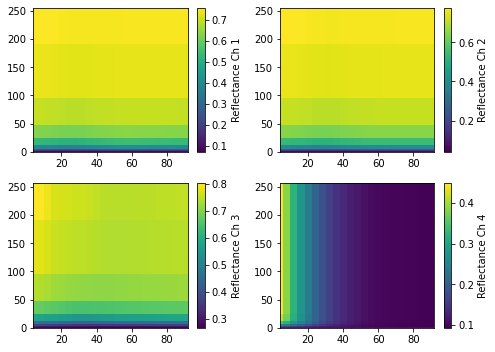

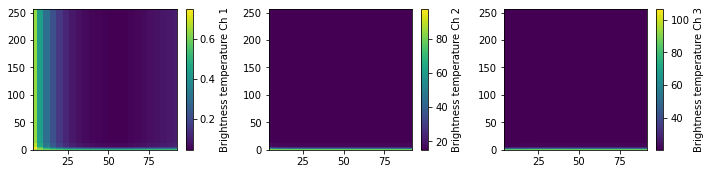

In [17]:
text_solar_fm.set_state(optical_depth=None, effective_radius=None)
solar_reflectance = text_solar_fm.reflectance()

xx, yy = text_ice.state_mesh()

text_therm_fm.set_state(optical_depth=None, effective_radius=None)
therm_radiance = text_therm_fm.radiance()

therm_radiance[...,text_therm_fm.pixel.solar] += (
    sol_const[text_solar_fm.pixel.thermal] *
    solar_reflectance[...,text_solar_fm.pixel.thermal]
)
therm_bt = np.apply_along_axis(
    lambda r: text_therm_fm.rad2temp(r)[0], 2, therm_radiance
)

fig, axes = plt.subplots(2, 2, figsize=(7, 5))
for i, ax in enumerate(axes.ravel()):
    im = ax.pcolormesh(xx, yy, solar_reflectance[...,i])
    fig.colorbar(im, ax=ax, label="Reflectance Ch {}".format(text_solar_fm.lut.channels[i]))
fig.tight_layout()

fig_, axes_ = plt.subplots(1, 3, figsize=(10, 2.5))
for i, ax in enumerate(axes_.ravel()):
    im_ = ax.pcolormesh(xx, yy, therm_radiance[...,i])
    fig_.colorbar(im_, ax=ax, label="Brightness temperature Ch {}".format(text_therm_fm.lut.channels[i]))
fig_.tight_layout()

TODO

- Use OracLut.uncertainty to generate a cost function surface
- Demonstrate the multilayer retrieval
- Demonstrate an aerosol retrieval